In [92]:
from typing import Literal, TypeAlias
from pprint import pprint
import time

import numpy as np
import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import seaborn as sns
from tqdm import tqdm

In [93]:
Sample: TypeAlias = list[int | float]
Data: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [165]:
# Activation functions

from abc import ABC, abstractmethod


class ActivationBase(ABC):
    @abstractmethod
    def calc(self, x: Sample) -> list[float]:
        """Apply the activation function to an layer output"""
        pass

    @abstractmethod
    def derivative(self, x: Sample):
        pass

#######################################


class ReLU(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return np.maximum(0, x)

    def derivative(self, x: Sample):
        return self.calc(x=x)


class Sigmoid(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: Sample):
        return x * (1-x)


class Softmax(ActivationBase):
    """returns model 'probabilities' for each class"""

    def calc(self, x: Sample) -> list[float]:
        
        # optimization: make numbers in an array from -inf to 0 because of a np.exp growing
        # and returns an array of floats from 0.0 to 1.0
        max_value = np.max(x)
        x -= max_value

        exp_values = np.exp(x)
        return exp_values / np.sum(exp_values)
    
    def derivative(self, x: Sample):
        pass

In [118]:
# Loss functions


class LossBase(ABC):
    @abstractmethod
    def calc(self, x: Sample, y: Target) -> float:
        """Apply the loss function to an output layer"""
        pass


class MSELoss(LossBase):
    """For regression""" 
    def calc(self, x: Sample, y: Target) -> float:

        x = np.argmax(x) + 1
        y = np.argmax(y)  +1

        loss = (y - x) ** 2

        return np.mean(loss)


class CrossEntropy(LossBase):
    """For classification"""
    def calc(self, x: Sample, y: Target) -> float:
        return -np.sum(y * np.log(x + 0.01))


In [8]:
a = [1, 100, 22, 99]

f = Softmax()

b = f.calc(a)
print(b)
print(sum(b))

[7.39262147e-44 7.31058579e-01 9.74950551e-35 2.68941421e-01]
1.0


In [96]:
class Dataset:
    def __init__(self, data: Data, targets: Targets) -> None:
        self.data: Data = data
        self._len = len(data)
        self.targets: Targets = targets

    def __len__(self) -> int:
        return self._len
    
    def __getitem__(self, index) -> Sample:
        return self.data[index]
    
    def __iter__(self):
        return iter(self.data)


In [97]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation: ActivationBase) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
        self.weights = self._init_weights()
        self.bias = self._init_bias()
        self.output = []

        self.activation = activation
    
    def _init_weights(self) -> list[float]:
        weights = np.random.randn(self.n_neurons, self.n_inputs) * 0.1
        return weights
    
    def _init_bias(self) -> list[float]:
        return np.random.randn(1)
    
    def forward(self, inputs) -> None:
        output = np.dot( self.weights, inputs)
        output += self.bias
        self.output = self.activation.calc(output)


Layers: TypeAlias = list[Linear]

In [320]:
class Model:
    def __init__(self, layers: Layers, loss: LossBase):
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss
    
    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True) -> list[float]:
        losses_by_epoch = []

        range_epoch = range(n_epoch)
        if verbose:
            range_epoch = tqdm(range_epoch, desc="epochs", position=0)

        for epoch in range_epoch:
            epoch_losses = []

            for i,sample in enumerate(dataset):
                sample = np.array(sample)

                # Forward pass
                self.layers[0].forward(inputs=sample) # input layer
                for j in range(1, self._layers_len):
                    self.layers[j].forward(inputs=self.layers[j-1].output)

                target = dataset.targets[i]


                # Calc loss
                output_error = self.calc_loss(target=target)
                epoch_losses.append(output_error)

                # Backward pass
                D = []
                delta = output_error * self.layers[-2].activation.derivative(x=self.layers[-1].output)
                D.append(delta)
                for i in range(self._layers_len - 2, -1, -1):
                    # error = np.dot(self.layers[i+1].weights.T, delta)
                    # delta =  self.layers[i].activation.derivative(x=self.layers[i].output) * error
                    # self.layers[i+1].weights += np.dot(delta, self.layers[i].output.T) * learning_rate

                    delta = np.dot(D[-1], self.layers[i-1].weights)
                    delta *= self.layers[i].activation.derivative(self.layers[i].output)
                    D.append(delta)
                
                # Update weights
                D = D[::-1]
                for i in range(self._layers_len):
                    self.layers[i].weights += np.dot(D[i], self.layers[i].output) * learning_rate
                # print(D)

            mean_loss = np.mean(epoch_losses)
            losses_by_epoch.append(mean_loss)
        
        return losses_by_epoch
    
    def predict(self, sample: Sample) -> list[float]:
        sample = np.array(sample)

        self.layers[0].forward(inputs=sample)
                
        for i in range(1, self._layers_len):
            self.layers[i].forward(inputs=self.layers[i-1].output)
        
        predict = self.layers[-1].output
        return predict
    
    def calc_loss(self, target: Target) -> float:
        output_layer = self.layers[-1]
        output = output_layer.output

        # print(output, target)

        loss = self.loss.calc(x=output, y=target)
        return loss

    
    def set_weights(self, weights: Weights) -> None:
        for w,layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

# Load dataset

In [12]:
dataset = load_iris()

In [13]:
dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [14]:
X, y = dataset['data'], dataset['target']

In [15]:
X[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [16]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# One-hot encoding

In [15]:
labels = set(y)
labels_len = len(labels)

labels

{np.int64(0), np.int64(1), np.int64(2)}

In [16]:
y_1 = []

for i in y:
    l = [0] * labels_len
    l[i] = 1
    y_1.append(l)
y_1

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0,

# Split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y_1, train_size=0.8)

In [18]:
train_dataset = Dataset(data=X_train, targets=y_train)
val_dataset = Dataset(data=X_val, targets=y_val)

# Model

In [333]:
layers = [
    Linear(4,1, activation=Sigmoid()),
    Linear(1,3, activation=Softmax()),
]

model = Model(layers=layers, loss=MSELoss())

In [334]:
losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.01, verbose=0)
losses

[np.float64(1.6)]

# Plots

In [335]:
losses

[np.float64(1.6)]

<Axes: >

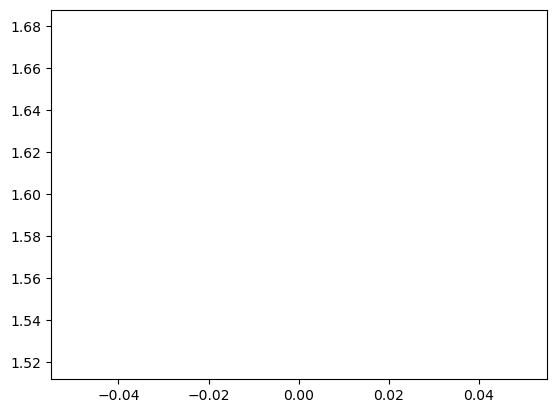

In [336]:
sns.lineplot(losses)

In [91]:
X_val[0]

array([5. , 3.4, 1.6, 0.4])

In [186]:
model.predict(X_train[1]), y_train[1]

(array([nan, nan, nan]), [0, 1, 0])

In [57]:
true_count = 0
all_count = 0

for sample,target in zip(X_train, y_train):
    pred = model.predict(sample=sample)

    pred = np.where(pred[0] >= max(pred[0]), 1, 0)
    # print(pred)
    # print(target)

    if list(pred) == target:
        true_count += 1
    all_count += 1 


acc = true_count / all_count
acc

TypeError: 'numpy.float64' object is not iterable